# Spam filter Life Cycle of the Project
###This notebook written by [me](https://github.com/vassert32) completely in English for my soft skills and for understanding by foreign users.
Notebook presents a step-by-step guide to building an efficient SMS spam classification model using the SMS Spam Collection dataset.


---

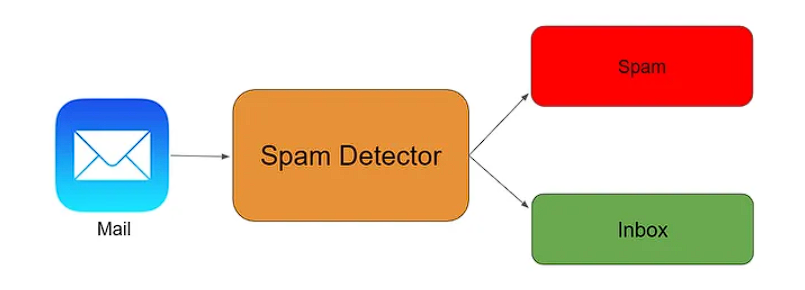

---

Dataset 1: https://www.kaggle.com/datasets/wcukierski/enron-email-dataset

Dataset 2: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset



# Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import collections
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score
from sklearn import metrics
from PIL import Image

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# 1. Data Loading and cleaning

In [2]:
!git clone 'https://github.com/vassert32/spam_filter_life_cycle'

Cloning into 'spam_filter_life_cycle'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 44 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (44/44), 359.35 KiB | 3.56 MiB/s, done.


In [34]:
df=pd.read_csv("/content/spam_filter_life_cycle/data/spam.csv", encoding='latin1') # read the data with encoding since there are special or latin characters
df.head(20) # check head

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [36]:
# drop unnamed columns
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'], inplace=True)

In [37]:
# rename columns
df.columns = ['target','text']

In [38]:
# create columns of length of message text
df['message_len'] = df['text'].apply(lambda x: len(x.split(' ')))
df.head()

,target,text,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


In [8]:
max(df['message_len'])

171

In [9]:
df.describe(include='all')

,target,text,message_len
count,5572,5572,5572.000000
unique,2,5169,NaN
top,ham,"Sorry, I'll call later",NaN
freq,4825,30,NaN
mean,NaN,NaN,15.606784
std,NaN,NaN,11.422465
min,NaN,NaN,1.000000
25%,NaN,NaN,7.000000
50%,NaN,NaN,12.000000
75%,NaN,NaN,23.000000


# 2. EDA

In [10]:
balance_counts = df.groupby('target')['target'].agg('count').values
balance_counts

array([4825,  747])

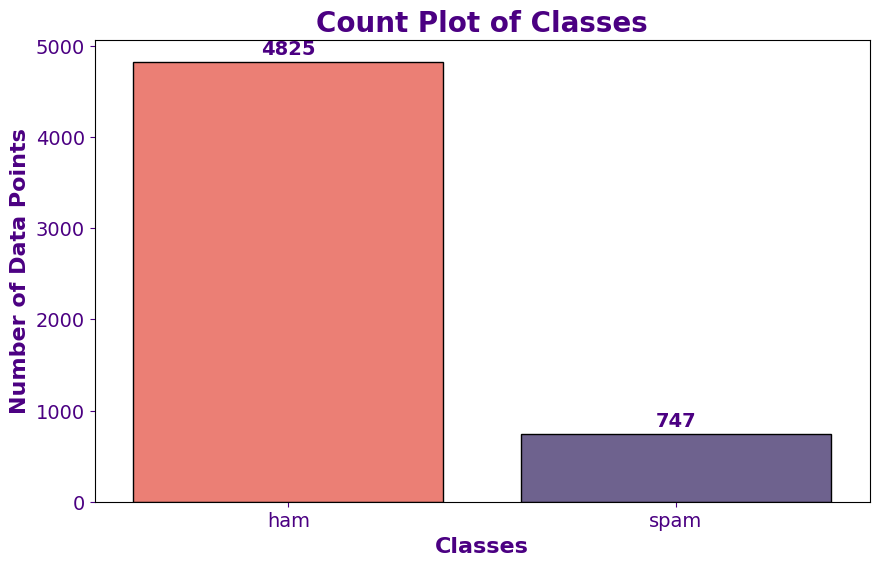

In [11]:
palette = ["#FF6F61", "#6B5B95"] # colors

plt.figure(figsize=(10, 6))

# creating countplot
fg = sns.countplot(x=df["target"], palette=palette, edgecolor="black")

# titles and labels
fg.set_title("Count Plot of Classes", color="#4B0082", fontsize=20, fontweight='bold')
fg.set_xlabel("Classes", color="#4B0082", fontsize=16, fontweight='bold')
fg.set_ylabel("Number of Data Points", color="#4B0082", fontsize=16, fontweight='bold')

# tick params
fg.tick_params(axis='x', colors='#4B0082', labelsize=14)
fg.tick_params(axis='y', colors='#4B0082', labelsize=14)

# add labels on top of bars
for p in fg.patches:
    fg.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points',
                color="#4B0082", fontsize=14, fontweight='bold')


plt.show()

In [12]:
values = df['target'].value_counts()
total = values.sum()

percentage_0 = (values[0] /total) * 100
percentage_1 = (values[1]/ total) *100

print('percentage of 0 :' ,percentage_0)
print('percentage of 1 :' ,percentage_1)

percentage of 0 : 86.59368269921033
percentage of 1 : 13.406317300789663


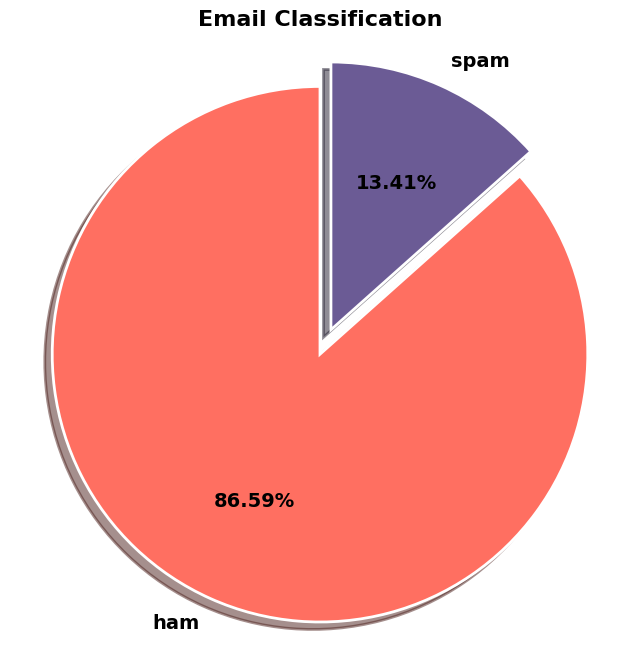

In [13]:
palette = ["#FF6F61", "#6B5B95"]


# define the explode parameter to create a gap between slices
explode = (0, 0.1)  # Explode the second slice (spam) by 10%

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_facecolor('00000')

# pie plot with custom params
wedges, texts, autotexts = ax.pie(
    values, labels=['ham', 'spam'],
    autopct='%0.2f%%',
    startangle=90,
    colors=palette,
    wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
    explode=explode,  # Apply the explode parameter
    shadow=True  # Add shadow
)
# text properties
for text, autotext in zip(texts, autotexts):
    text.set(size=14, weight='bold')
    autotext.set(size=14, weight='bold')

ax.set_title('Email Classification', fontsize=16, fontweight='bold')

ax.axis('equal')

plt.show()

###**We can clearly see how our data is imbalanced.**

---

  target  message_len
0    ham    14.323938
1   spam    23.892905


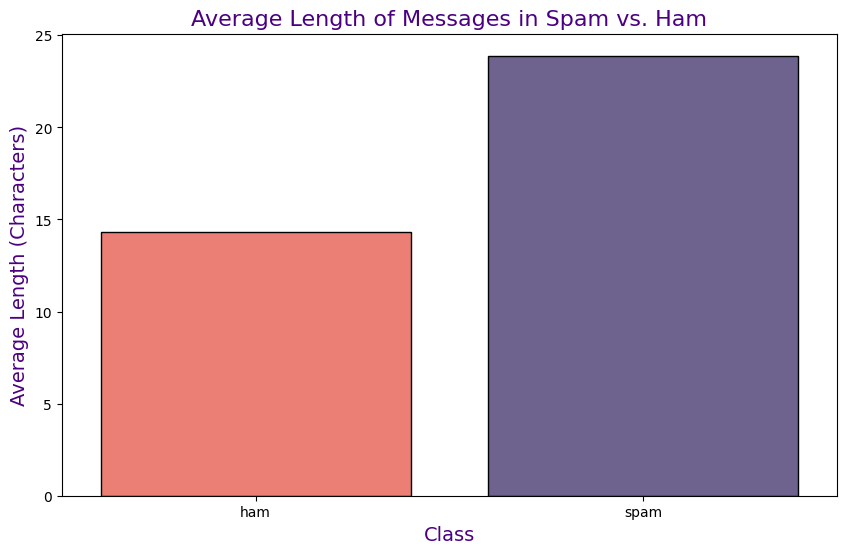

In [14]:
palette = ["#FF6F61", "#6B5B95"]

# average lenght by grouping messages
average_length = df.groupby('target')['message_len'].mean().reset_index()
print(average_length)
# count plot of avg lenght
plt.figure(figsize=(10, 6))
sns.barplot(x='target', y='message_len', data=average_length, palette=palette, edgecolor='black')
plt.title('Average Length of Messages in Spam vs. Ham', fontsize=16, color='#4B0082')
plt.xlabel('Class', fontsize=14, color='#4B0082')
plt.ylabel('Average Length (Characters)', fontsize=14, color='#4B0082')
plt.show()

###**Average length of spam message is bigger than ham message.** (almost double)*

---

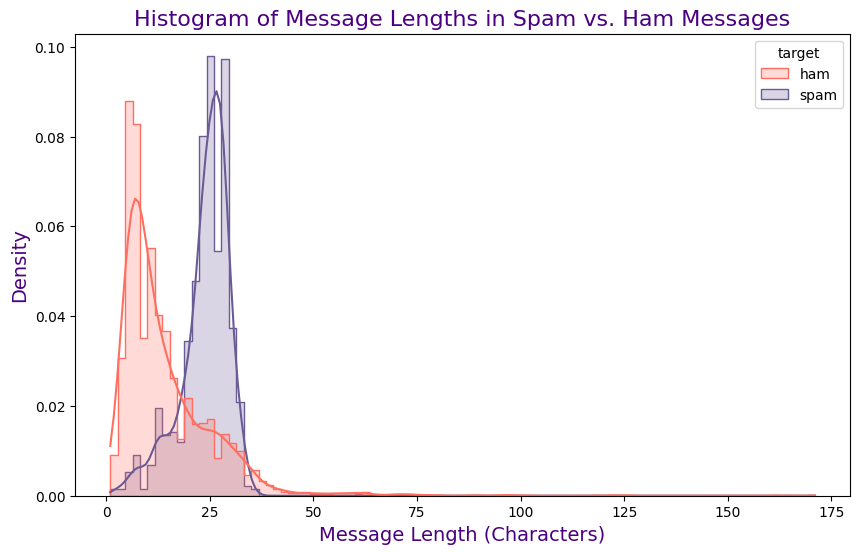

In [15]:
# histogram plot
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='message_len', hue='target', palette=palette, element='step', stat='density', common_norm=False, kde=True)
plt.title('Histogram of Message Lengths in Spam vs. Ham Messages', fontsize=16, color='#4B0082')
plt.xlabel('Message Length (Characters)', fontsize=14, color='#4B0082')
plt.ylabel('Density', fontsize=14, color='#4B0082')
plt.show()

In [16]:
df.loc[df['message_len'].idxmax()].target

'ham'

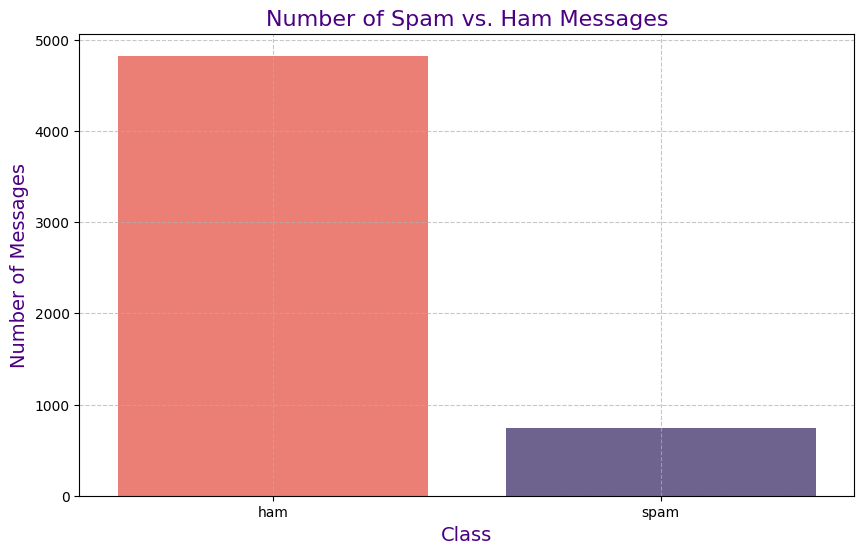

In [17]:
# countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=df, palette=palette)
plt.title('Number of Spam vs. Ham Messages', fontsize=16, color='#4B0082')
plt.xlabel('Class', fontsize=14, color='#4B0082')
plt.ylabel('Number of Messages', fontsize=14, color='#4B0082')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

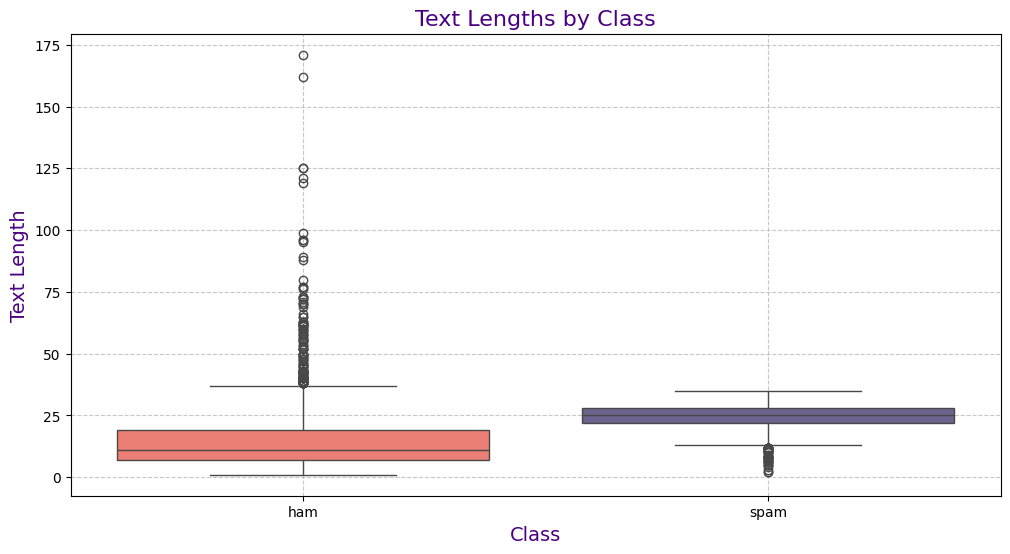

In [18]:
# boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(x='target', y='message_len', data=df, palette=palette)
plt.title('Text Lengths by Class', fontsize=16, color='#4B0082')
plt.xlabel('Class', fontsize=14, color='#4B0082')
plt.ylabel('Text Length', fontsize=14, color='#4B0082')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

###**All plots showing the difference between these two statements.**

-----------

##***Word clouds***

In [19]:
# getting only spam messages and concat to 1 sequence
spam_texts = ' '.join(df[df['target'] == 'spam']['text'])
ham_texts = ' '.join(df[df['target'] == 'ham']['text'])
all_texts = ' '.join(df['text'])

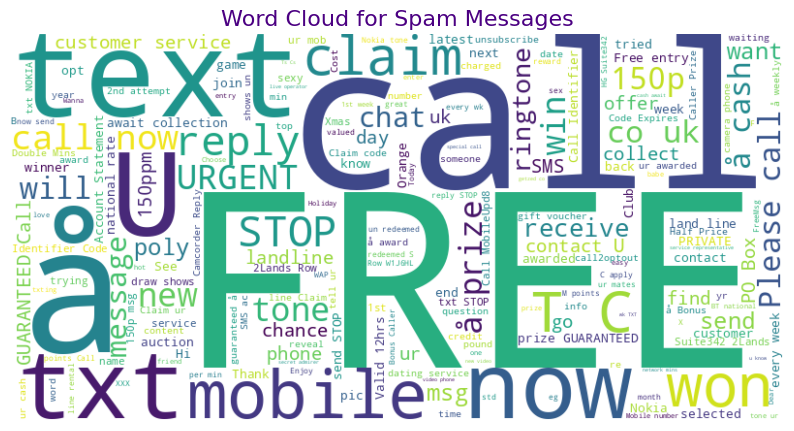

In [20]:
# generate a spam word cloud
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(spam_texts)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Spam Messages', fontsize=16, color='#4B0082')
plt.show()

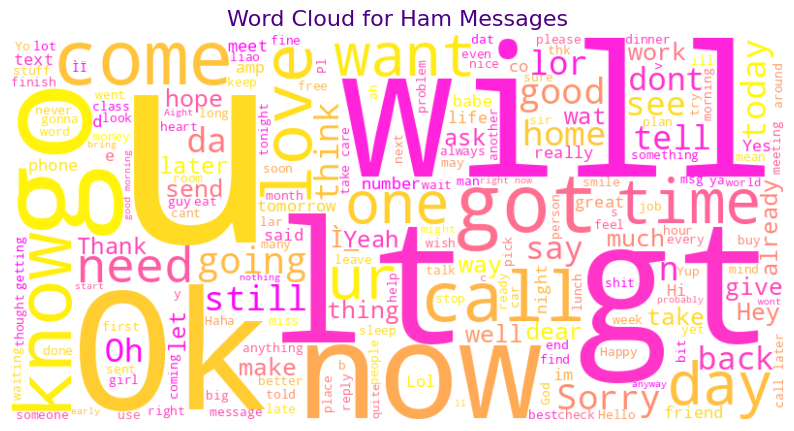

In [21]:
# generate a ham word cloud
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='spring').generate(ham_texts)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Ham Messages', fontsize=16, color='#4B0082')
plt.show()

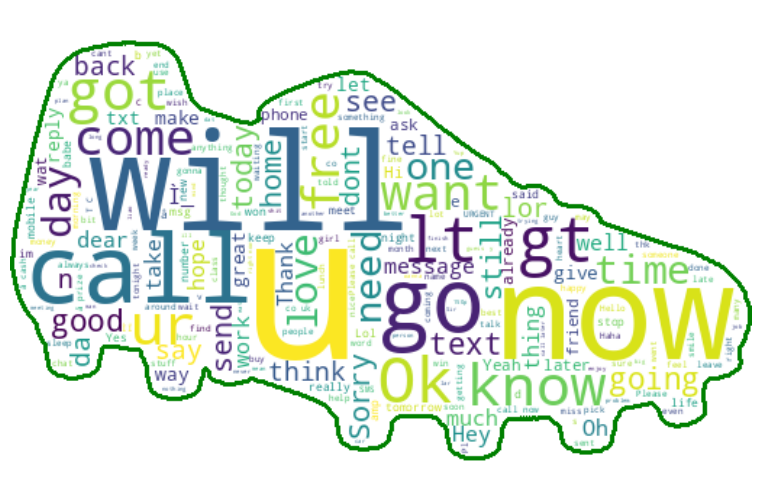

<Figure size 640x480 with 0 Axes>

In [22]:
from wordcloud import WordCloud, STOPWORDS

mask_image = np.array(Image.open('/content/spam_filter_life_cycle/data/butsa.png'))

plt.figure(figsize=(10, 6))

wc = WordCloud(width=1000, height=500, background_color="white", max_words=2000, mask=mask_image, contour_width=2, contour_color='green')

# generate word cloud
wc.generate(all_texts)

# store to file
wc.to_file('/content/spam_filter_life_cycle/data/cloud.png')

# show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.show()

---

###***Common words by group***

In [23]:
def most_common_group(target, palette):
    words = ' '.join(df[df['target'].isin(target)]['text'])

    words_tokens = nltk.word_tokenize(words)

    # remove stop words and non-alphabetic tokens
    stop_words = set(stopwords.words('english'))
    filtered_words = [word.lower() for word in words_tokens if word.isalpha() and word.lower() not in stop_words]

    # frequency of most common words
    word_freq = collections.Counter(filtered_words)
    most_common_words = word_freq.most_common(10)
    words, counts = zip(*most_common_words)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(words), y=list(counts), palette=palette, edgecolor='black')
    plt.title('Top 10 Most Common Words in Spam Messages', fontsize=16, color='#4B0082')
    plt.xlabel('Words', fontsize=14, color='#4B0082')
    plt.ylabel('Frequency', fontsize=14, color='#4B0082')
    plt.xticks(rotation=45)
    plt.show()

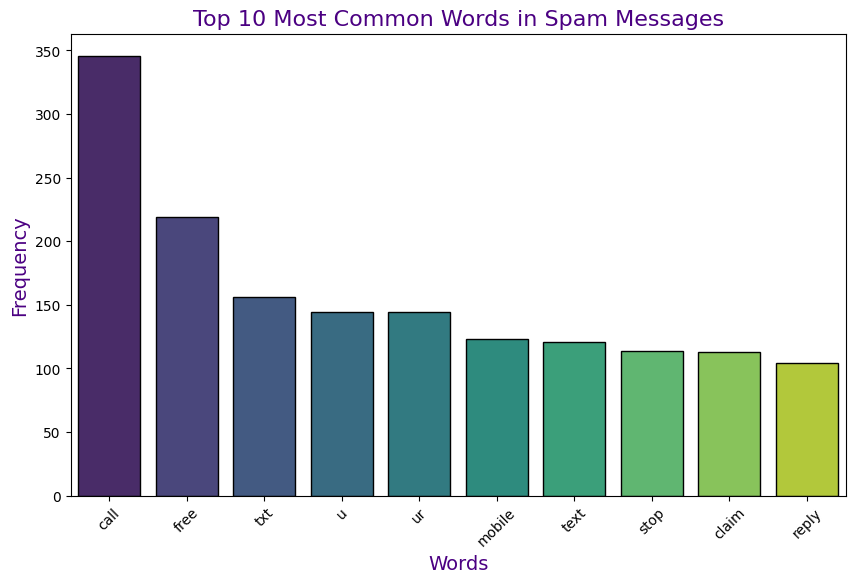

In [24]:
most_common_group(['spam'], 'viridis')

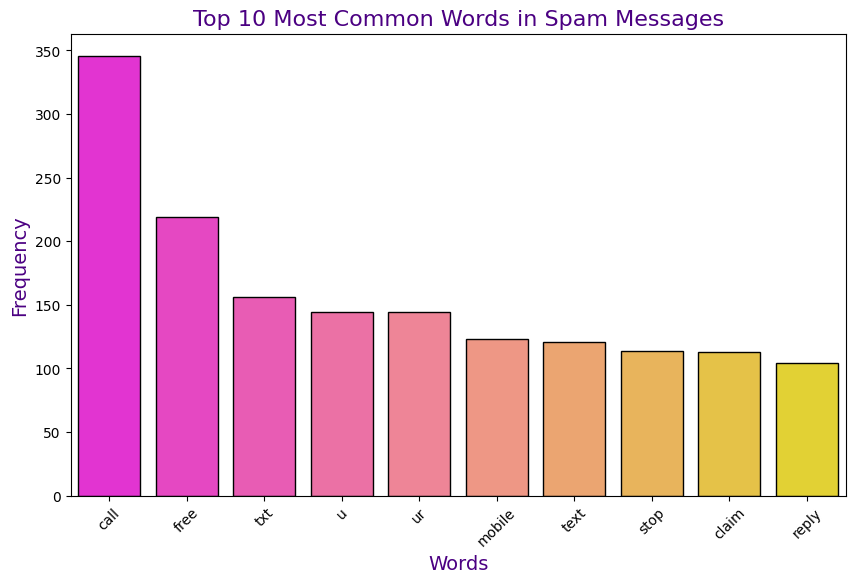

In [25]:
most_common_group(['spam'], 'spring')

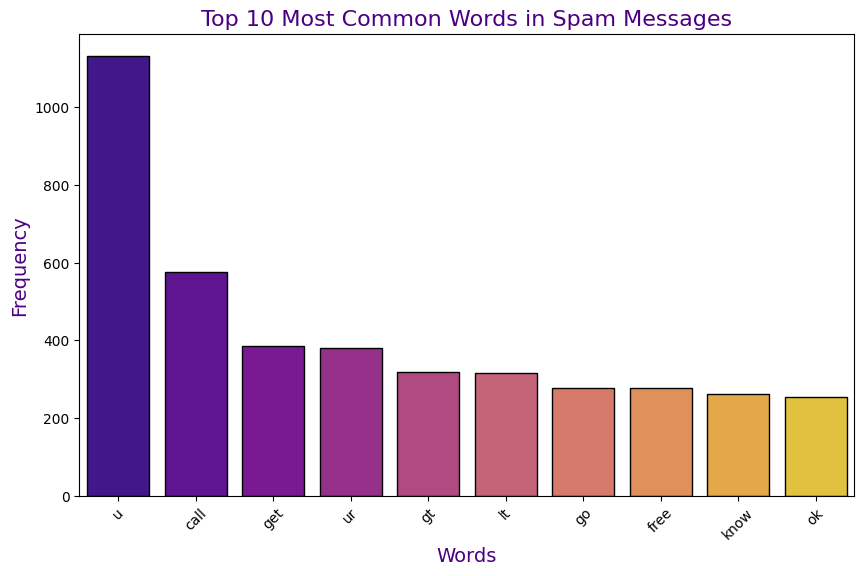

In [26]:
most_common_group(['spam', 'ham'], 'plasma')

---

# 3. Preprocessing

In [39]:
# drop outliers
df = df[(df["message_len"]<350)]
df.shape

(5572, 3)

In [40]:
print("\033[1m\u001b[45;1m The First 5 Texts:\033[0m",*df["text"][:5], sep = "\n")

 The First 5 Texts:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Ok lar... Joking wif u oni...
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
U dun say so early hor... U c already then say...
Nah I don't think he goes to usf, he lives around here though


In [41]:
# cleaning function
def cleaning_text(text):
    sms = re.sub('[^a-zA-Z]', ' ', text)
    sms = sms.lower()
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

df["cleaned_text"] = df["text"].apply(cleaning_text)

print("\033[1m\u001b[45;1m The First 5 Texts:\033[0m",*df["cleaned_text"][:5], sep = "\n")

 The First 5 Texts:
go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


In [42]:
# tokenizing
df["token_text"]=df.apply(lambda row: nltk.word_tokenize(row["cleaned_text"]), axis=1)

print("\033[1m\u001b[45;1m The First 5 Texts after Tokenizing:\033[0m",*df["token_text"][:5], sep = "\n")

 The First 5 Texts after Tokenizing:
['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']


In [43]:
# removing stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

df["no_sw_text"] = df["token_text"].apply(remove_stopwords)

print("\033[1m\u001b[45;1m The First 5 Texts after removing the stopwords:\033[0m",*df["no_sw_text"][:5], sep = "\n")

 The First 5 Texts after removing the stopwords:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']


In [49]:
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
# lemmatize string
def lemmatize_word(text):
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

df["lemm_text"] = df["no_sw_text"].apply(lemmatize_word)

print("\033[1m\u001b[45;1m The First 5 texts after lemitization:\033[0m",*df["lemm_text"][:5], sep = "\n")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


 The First 5 texts after lemitization:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'get', 'amore', 'wat']
['ok', 'lar', 'joke', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'go', 'usf', 'live', 'around', 'though']
